## 1. Prepare Environment

In [1]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="../.envfiles/dev.env")

True

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
from src.db import OptoFile
from src.spectra import Sample


subjects = ['s1', 's2', 's3', 's4', 's5', 
            's6', 's7', 's8', 's9', 's10', 
            's11', 's12', 's13']

## 2. DB

Loaded subject s1 with 25 samples, of which 25 have glucose_target values.
Loaded subject s2 with 26 samples, of which 10 have glucose_target values.
Loaded subject s3 with 30 samples, of which 12 have glucose_target values.
Loaded subject s4 with 32 samples, of which 12 have glucose_target values.
Loaded subject s5 with 28 samples, of which 12 have glucose_target values.
Loaded subject s6 with 27 samples, of which 10 have glucose_target values.
Loaded subject s7 with 26 samples, of which 10 have glucose_target values.
Loaded subject s8 with 26 samples, of which 10 have glucose_target values.
Loaded subject s9 with 32 samples, of which 12 have glucose_target values.
Loaded subject s10 with 26 samples, of which 10 have glucose_target values.
Loaded subject s11 with 26 samples, of which 10 have glucose_target values.
Loaded subject s12 with 29 samples, of which 10 have glucose_target values.
Loaded subject s13 with 27 samples, of which 9 have glucose_target values.


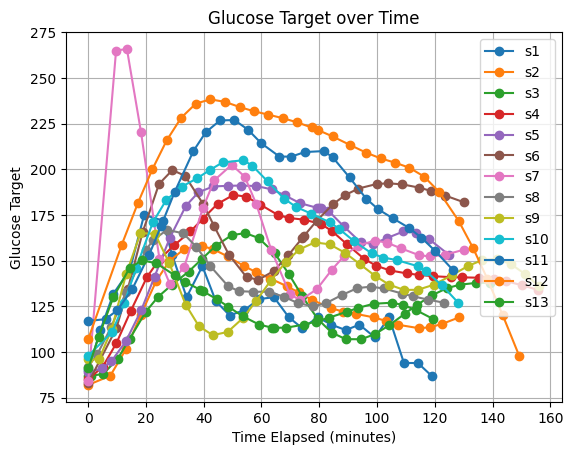

In [3]:
async def load_subject(subject_id:str) -> pd.DataFrame:
    # Index(['subject_id', 'header', 'file_version', 'name', 'creator',
    #        'description', 'created', 'integration_time', 'laser_power',
    #        'average_number', 'scan_mode', 'scan_interval', 'device_model',
    #        'pixel_num', 'device_sn', 'pretreat', 'pixel', 'raman_shift', 'raw',
    #        'dark', 'dark_subtracted', 'baseline_subtracted', 'prick_time',
    #        'glucose_target', 'is_interpolated', 'glucose_predict', 'id',
    #        'elapsed_seconds'],
    #       dtype='object')
    samples:list[OptoFile] = await OptoFile.fetch_all(subject_id=subject_id)
    assert len(samples) > 0
    df = pd.DataFrame([sample.model_dump() for sample in samples])
    df = df[['subject_id', 'created', 'prick_time', 'glucose_target', 'is_interpolated', 'raman_shift', 'raw', 'dark', 'dark_subtracted', 'baseline_subtracted']]
    df['elapsed_seconds'] = [diff.total_seconds() for diff in df.created - df.iloc[0].created]
    df_w_value = df[df.glucose_target.isnull() == False]
    # Interpolate missing glucose_target values using Cubic Spline
    cs = CubicSpline(df_w_value['elapsed_seconds'], df_w_value['glucose_target'], bc_type="natural")
    df['glucose_interpolated'] = cs(df['elapsed_seconds'])
    print(f"Loaded subject {subject_id} with {len(df)} samples, of which {len(df_w_value)} have glucose_target values.")
    return df

dataset = [df for df in [await load_subject(subject_id=subject_id) for subject_id in subjects]]

count = 0
for df in dataset:
    elapsed_seconds = df['elapsed_seconds'] / 60.0  # Convert to minutes
    glucoses = df['glucose_interpolated']
    plt.plot(elapsed_seconds, glucoses, marker='o', label=df['subject_id'].iloc[0])
    # if(count >= 1):
    #     break
    count += 1

plt.xlabel('Time Elapsed (minutes)')
plt.ylabel('Glucose Target')
plt.title('Glucose Target over Time')
plt.grid()
plt.legend()
plt.show()

In [4]:
dataset = pd.concat(dataset, ignore_index=True)
dataset

,subject_id,created,prick_time,glucose_target,is_interpolated,raman_shift,raw,dark,dark_subtracted,baseline_subtracted,elapsed_seconds,glucose_interpolated
0,s1,2025-09-25 08:16:44,2025-09-25 08:15:00,90.0,False,"[191.1294, 193.9154, 196.7002, 199.4839, 202.2...","[43066.4, 43066.4, 43066.4, 43066.4, 43066.4, ...","[27174.8, 27174.8, 27174.8, 27174.8, 27174.8, ...","[15891.6, 15891.6, 15891.6, 15891.6, 15891.6, ...","[389.1032, 393.2731, 397.6122, 402.1241, 406.8...",0.0,90.000000
1,s1,2025-09-25 08:20:57,2025-09-25 08:20:00,112.0,False,"[191.1294, 193.9154, 196.7002, 199.4839, 202.2...","[43331.2, 43331.2, 43331.2, 43331.2, 43331.2, ...","[27289.8, 27289.8, 27289.8, 27289.8, 27289.8, ...","[16041.4, 16041.4, 16041.4, 16041.4, 16041.4, ...","[379.6331, 383.5506, 387.6291, 391.8719, 396.2...",253.0,112.000000
2,s1,2025-09-25 08:25:29,2025-09-25 08:25:00,132.0,False,"[191.1294, 193.9154, 196.7002, 199.4839, 202.2...","[43996.0, 43996.0, 43996.0, 43996.0, 43996.0, ...","[27394.8, 27394.8, 27394.8, 27394.8, 27394.8, ...","[16601.2, 16601.2, 16601.2, 16601.2, 16601.2, ...","[263.6184, 267.2868, 271.1085, 275.0872, 279.2...",525.0,132.000000
3,s1,2025-09-25 08:31:10,2025-09-25 08:30:00,145.0,False,"[191.1294, 193.9154, 196.7002, 199.4839, 202.2...","[43745.2, 43745.2, 43745.2, 43745.2, 43745.2, ...","[27242.8, 27242.8, 27242.8, 27242.8, 27242.8, ...","[16502.4, 16502.4, 16502.4, 16502.4, 16502.4, ...","[296.3765, 300.6178, 305.0327, 309.6249, 314.3...",866.0,145.000000
4,s1,2025-09-25 08:36:05,2025-09-25 08:35:00,175.0,False,"[191.1294, 193.9154, 196.7002, 199.4839, 202.2...","[43416.6, 43416.6, 43416.6, 43416.6, 43416.6, ...","[27198.2, 27198.2, 27198.2, 27198.2, 27198.2, ...","[16218.4, 16218.4, 16218.4, 16218.4, 16218.4, ...","[222.8331, 226.6198, 230.5636, 234.668, 238.93...",1161.0,175.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
355,s13,2025-10-13 11:05:13,NaT,NaN,False,"[191.1294, 193.9154, 196.7002, 199.4839, 202.2...","[57922.4, 57922.4, 57922.4, 57922.4, 57922.4, ...","[41033.8, 41033.8, 41033.8, 41033.8, 41033.8, ...","[16888.6, 16888.6, 16888.6, 16888.6, 16888.6, ...","[1600.3315, 1605.811, 1611.4964, 1621.5885, 16...",5929.0,126.431724
356,s13,2025-10-13 11:11:40,2025-10-13 11:10:00,127.0,False,"[191.1294, 193.9154, 196.7002, 199.4839, 202.2...","[57292.0, 57292.0, 57292.0, 57292.0, 57292.0, ...","[40788.2, 40788.2, 40788.2, 40788.2, 40788.2, ...","[16503.8, 16503.8, 16503.8, 16503.8, 16503.8, ...","[1732.6507, 1738.4054, 1744.3776, 1751.6669, 1...",6316.0,127.000000
357,s13,2025-10-13 11:15:29,NaT,NaN,False,"[191.1294, 193.9154, 196.7002, 199.4839, 202.2...","[57816.0, 57816.0, 57816.0, 57816.0, 57816.0, ...","[41009.8, 41009.8, 41009.8, 41009.8, 41009.8, ...","[16806.2, 16806.2, 16806.2, 16806.2, 16806.2, ...","[1736.3907, 1741.9662, 1747.7494, 1758.1078, 1...",6545.0,125.695671
358,s13,2025-10-13 11:19:54,NaT,NaN,False,"[191.1294, 193.9154, 196.7002, 199.4839, 202.2...","[58424.2, 58424.2, 58424.2, 58424.2, 58424.2, ...","[41065.6, 41065.6, 41065.6, 41065.6, 41065.6, ...","[17358.6, 17358.6, 17358.6, 17358.6, 17358.6, ...","[1750.1454, 1755.676, 1761.4121, 1773.2746, 17...",6810.0,122.939567


((360, 801), (360,))

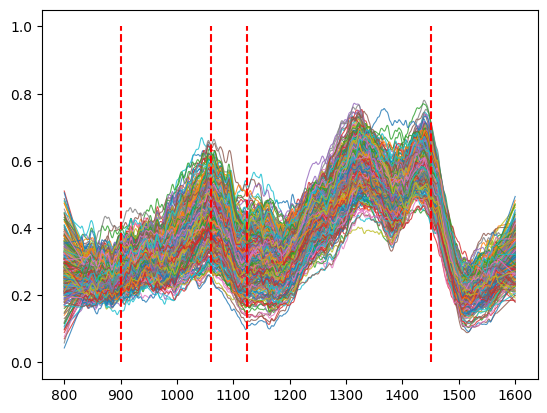

In [105]:
X = []
y = []
for row in dataset.itertuples():
    sample = Sample(
        x=np.array(row.raman_shift),
        y=np.array(row.baseline_subtracted),
        interpolate=False,
        verbose=True
    )
    sample.despike(window_length=10,threshold=5)
    sample.interpolate(step=1)
    sample.extract_range(low=800, high=1600)
    sample.normalized(method='minmax')
    sample.smoothing(window_length=60, polyorder=1)
    # f835  = sample.at(np.arange(830, 850)).mean()
    # f910  = sample.at(np.arange(905, 950)).mean()
    # f1100 = sample.at(np.arange(1105, 1120)).mean()
    # f1150 = sample.at(np.arange(1160, 1180)).mean()
    # f1210 = sample.at(np.arange(1210, 1230)).mean()
    # f1270 = sample.at(np.arange(1270, 1300)).mean()
    # f1330 = sample.at(np.arange(1335, 1340)).mean()
    # f1450 = sample.at(np.arange(1419, 1455)).mean()
    # f1530 = sample.at(np.arange(1530, 1570)).mean()
    # f1125 = sample.at(np.arange(1120, 1130)).mean()
    # print(f1450)
    # f911  = sample.at(np.arange(905, 915)).mean()
    # f1060 = sample.at(np.arange(1050, 1070)).mean()
    # f1125 = sample.at(np.arange(1125, 1170)).mean()
    # f1450 = sample.at(np.arange(1440, 1460)).mean()
    # X.append(np.array([f835,f910,f1100,f1150,f1210,f1270,f1330,f1450,f1530]))
    # X.append(np.hstack([f835,f910,f1100,f1150,f1210,f1270,f1330,f1450,f1530]))
    # X.append(np.array([f911, f1060, f1125/f1450]))
    X.append(sample.y)
    y.append(row.glucose_interpolated)
    sample.plot()
    # y.append(row.glucose_target)
    
plt.vlines(ymin=0, ymax=1, x=[900, 1060, 1125, 1450], color='red', linestyle='--')
X = np.array(X)
y = np.array(y)
# X = X[y > 0]
# y = y[y > 0]
X.shape, y.shape

<Axes: >

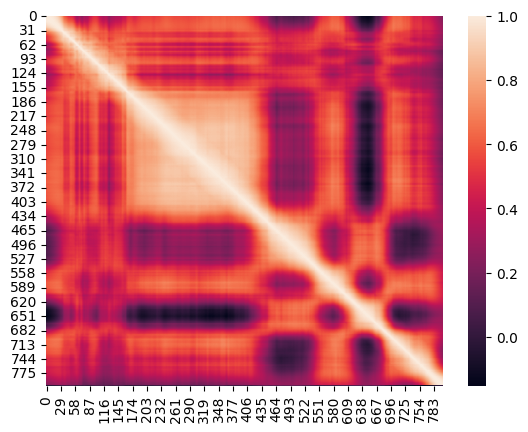

In [106]:
import seaborn as sns
cor = np.corrcoef(np.hstack([X,y.reshape(-1,1)]).T)
sns.heatmap(cor, annot=False)

In [107]:
a = abs(cor[:,-1])
print(a[a.argsort()[::-1]])
print(a.argsort()[::-1][:150] + 800)
print(sorted(a.argsort()[::-1][:150] + 800))
# , np.arange(800,1600))


[1.00000000e+00 1.52694845e-01 1.52657585e-01 1.51648492e-01
 1.50907173e-01 1.50455001e-01 1.50270278e-01 1.49547106e-01
 1.48288174e-01 1.46225377e-01 1.45907409e-01 1.45841379e-01
 1.44978276e-01 1.44215319e-01 1.43964882e-01 1.43919563e-01
 1.43702151e-01 1.42995077e-01 1.41838154e-01 1.41097967e-01
 1.40634062e-01 1.40347691e-01 1.40146316e-01 1.39860796e-01
 1.38733924e-01 1.36670430e-01 1.36557781e-01 1.36499352e-01
 1.36296673e-01 1.35501223e-01 1.35498410e-01 1.35323248e-01
 1.34697106e-01 1.34567478e-01 1.34367927e-01 1.34178143e-01
 1.33349973e-01 1.33236070e-01 1.33162901e-01 1.32689393e-01
 1.32656702e-01 1.32537490e-01 1.32418684e-01 1.32333461e-01
 1.32219049e-01 1.31959117e-01 1.31532835e-01 1.31048769e-01
 1.31009337e-01 1.30953743e-01 1.30803819e-01 1.30758572e-01
 1.30562506e-01 1.30524516e-01 1.30238482e-01 1.29911988e-01
 1.29824279e-01 1.29804158e-01 1.29669711e-01 1.29526954e-01
 1.29318954e-01 1.28762391e-01 1.28714776e-01 1.28382606e-01
 1.28107072e-01 1.281018

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA

def train(modelcls, X ,y):
    split = RepeatedKFold(n_splits=5, n_repeats=4, random_state=24)
    best_model = None
    best_pca = None
    best_error = np.inf
    count = 0
    errors = []
    for train, test in split.split(X):
        X_train, y_train = X[train], y[train]
        X_test, y_test = X[test], y[test]
        pca = PCA(n_components=25)
        X_train = pca.fit_transform(X_train)
        # Train
        model = None
        if(modelcls == 'mlp'):
            model = MLPRegressor(solver='adam', learning_rate='adaptive', max_iter=100000, hidden_layer_sizes=100, activation='identity')
        else:
            # model = LinearRegression()
            # model = RandomForestRegressor()
            # model = GradientBoostingRegressor()
            # model = AdaBoostRegressor()
            model = modelcls()
        model = model.fit(X_train,y_train.reshape(-1))
        # Test
        X_test = pca.transform(X_test)
        y_hat = model.predict(X_test)
        error = mean_squared_error(y_pred=y_hat,y_true=y_test)
        errors.append(error)
        if(best_error > error):
            best_model = model
            best_error = error
            best_pca = pca
        count = count + 1
    return best_model, best_pca, best_error, np.std(errors)


In [113]:
models = [LinearRegression,
            RandomForestRegressor,
            GradientBoostingRegressor,
            AdaBoostRegressor,
            'mlp']
best_models = []
best_pcas = []
best_errors = []
stds = []
for model in models:
    best_model, best_pca, best_error, std = train(model, X, y)
    print(best_error)
    best_models.append(best_model)
    best_pcas.append(best_pca)
    best_errors.append(best_error)
    stds.append(std)

889.1516931870126
851.6269405626185
926.9748329314631
845.4501066837973
870.0927390511005


In [114]:
model_names = ['LinearRegression','RandomForestRegressor','GradientBoostingRegressor',"AdaBoostRegressor",'MLPRegressor']
for model_name, best_error, best_model, std in zip(model_names, best_errors, best_models, stds):
    print(model_name, best_error, std, sep='\t')

LinearRegression	889.1516931870126	203.29252801104036
RandomForestRegressor	851.6269405626185	201.12948840687713
GradientBoostingRegressor	926.9748329314631	213.88687851469555
AdaBoostRegressor	845.4501066837973	230.96551240000096
MLPRegressor	870.0927390511005	202.19034402049877


(0, 0)
(0, 1)
(1, 0)
(1, 1)
(2, 0)


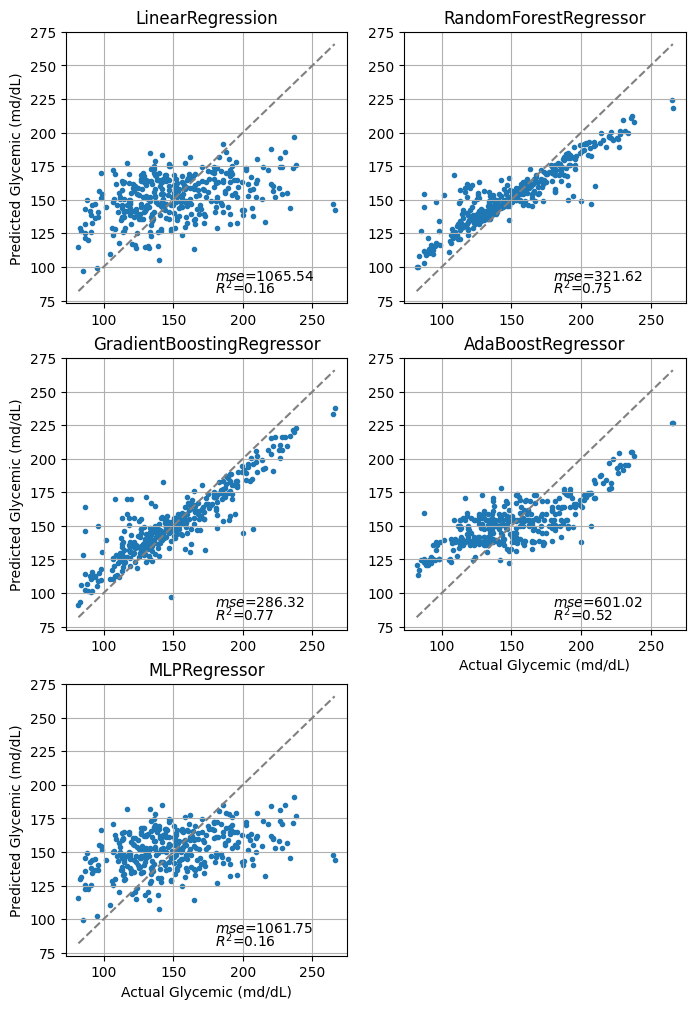

In [115]:
from itertools import product
fig,ax = plt.subplots(figsize=(8,12), ncols=2, nrows=3)
for idx, (model_name, model, pca, coord) in enumerate(zip(model_names, best_models, best_pcas, product([0,1,2],[0,1]))):
    print(coord)
    # y_hat = model.predict(X)
    y_hat = model.predict(pca.transform(X))
    # y_scale = scaler.transform(y.reshape(-1,1))
    # print(X.shape, y_hat.shape, y_scale.shape)
    mse = np.round(mean_squared_error(y_pred=y_hat,y_true=y),2)
    r2 = np.round(r2_score(y_pred=y_hat,y_true=y),2)
    ax[coord[0]][coord[1]].scatter(x=y, y=y_hat, marker='.')
    # ax.scatter(x=y[groups == 1], y=y_hat[groups == 1], color='blue', label='old tube')
    # ax.scatter(x=y[groups == 2], y=y_hat[groups == 2], color='red', label='new tube')
    

    min_xy = min(min(y), min(y_hat))
    max_xy = max(max(y), max(y_hat))
    ax[coord[0]][coord[1]].plot([min_xy, max_xy], [min_xy, max_xy], linestyle='--', color='grey')
    # if(model_name == 'LinearRegression'):
    #     ax[coord[0]][coord[1]].text(180,0,s=f'$R^2$={r2:.2f}')
    #     ax[coord[0]][coord[1]].text(180,20,s=f'$mse$={mse:.2f}')
    # else:
    ax[coord[0]][coord[1]].text(180,80,s=f'$R^2$={r2:.2f}')
    ax[coord[0]][coord[1]].text(180,90,s=f'$mse$={mse:.2f}')
    if(coord[0] == 2 or (coord[1] == 1 and coord[0] == 1)):
        ax[coord[0]][coord[1]].set_xlabel('Actual Glycemic (md/dL)')
    if(coord[1] == 0):
        ax[coord[0]][coord[1]].set_ylabel('Predicted Glycemic (md/dL)')
    ax[coord[0]][coord[1]].set_title(model_name)
    # ax.legend()
    ax[coord[0]][coord[1]].grid()
fig.delaxes(ax[2][1])
plt.show()



In [ ]:
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA

cv = RepeatedKFold(n_splits=5, n_repeats=4, random_state=1)
best_model = None
best_score = -float('inf')
best_PCA = None
for train_index, test_index in cv.split(X,y):
    print("train_szie:", len(train_index), "test_size:", len(test_index))
    X_train = X[train_index]
    y_train = y[train_index]
    X_test  = X[test_index]
    y_test  = y[test_index]


    # pca = PCA(n_components=25)
    # X_train = pca.fit_transform(X_train)
    # X_test = pca.transform(X_test)
    
    model = RandomForestRegressor()

    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    # print(y_hat)
    # Evaluate model performance
    mse = mean_squared_error(y_test, y_hat)
    r2 = r2_score(y_test, y_hat)
    if r2 > best_score:
        best_score = r2
        best_model = model
        best_PCA = pca
    print(f'Mean Squared Error: {mse}', f'R^2 Score: {r2}')

train_szie: 288 test_size: 72
Mean Squared Error: 962.682994787767 R^2 Score: -0.01142445857609431
train_szie: 288 test_size: 72
Mean Squared Error: 872.0717730399617 R^2 Score: 0.11475167780452877
train_szie: 288 test_size: 72
Mean Squared Error: 1628.6217934450426 R^2 Score: -0.018103134716185965
train_szie: 288 test_size: 72
Mean Squared Error: 1166.246756935946 R^2 Score: 0.11200376382068522
train_szie: 288 test_size: 72
Mean Squared Error: 1176.6985674887994 R^2 Score: 0.14802763832152466
train_szie: 288 test_size: 72
Mean Squared Error: 1088.836690885995 R^2 Score: 0.20958858327920749
train_szie: 288 test_size: 72
Mean Squared Error: 1251.7888684803538 R^2 Score: 0.03060265483543234
train_szie: 288 test_size: 72
Mean Squared Error: 1195.3133212596576 R^2 Score: -0.0804082632567773
train_szie: 288 test_size: 72
Mean Squared Error: 1498.7371295855878 R^2 Score: -0.0726344941946453
train_szie: 288 test_size: 72
Mean Squared Error: 920.9568552577764 R^2 Score: 0.08190010966896599
tra

In [91]:
# y_hat = best_model.predict(best_PCA.transform(X))
y_hat = best_model.predict(X)
mean_squared_error(y, y_hat), r2_score(y, y_hat)

(358.42160437546875, 0.7161986902318263)